# Importing the Dataset and Packages


## Import Script
The powershell in the assosiated GitHub repository allows for this notebook to download the datasetfor this project, provided you complete the ".env" file with your kaggle API key, and file path.

This script was written, so that this notebook may be run, tested, and modified either in the kaggle environment, or on a configured windows machine.

In [1]:
import warnings
import math
import dotenv
import kagglehub
import os
import subprocess
import ipywidgets
import sklearn as sk
import pandas as pd
import tensorflow as tf
import keras as ks
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sb


from scipy.stats import anderson, lognorm, probplot, shapiro
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


try:
    dotenv.load_dotenv()
except:
    print("--Dotenv not loaded--")


# Check for Kaggle environment and set the file path
if os.path.exists("/kaggle/input/churn-modelling/Churn_Modelling.csv"):
    # Kaggle
    file_path = "/kaggle/input/churn-modelling/Churn_Modelling.csv"
else:
    # Local
    file_path = (str((os.getenv("LOCAL_FILE_LOCATION"))))

# Load Dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully!")
except FileNotFoundError:
    print(f"Error: File not found at : file_path")
    try:
        print("Attempting to run download_data_ps1")
        path = os.getenv("SCRIPT_PATH")
        subprocess.run(["powershell", "-ExecutionPolicy", "Bypass", "-File", path],
                       check = True, capture_output =  True, text = True)
        print("Powershell Download Script Run Successfully. Now attempting to reload dataset...")
        df = pd.read_csv(file_path)
        if df is not None and not df.empty:
            print("Dataset Loaded Successfully")
        else:
            print("Data not loaded")
    except Exception as e:
        print(f"Error running powershell script: {e}")
        df = None

# Display the first few rows of the dataset
if df is not None:
    display(df.head())

Dataset Loaded Successfully!


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Cleaning Dataset

The target variable is the last variable in this dataset. It is called "Exited". It is binary, where a 1 represents a customer closing thier account, and a 0 represents a retained customer.

Let's preview the data in order to understand what we have to work with.

First, I will drop the insignificant variables, which are the "RowNumber", "CustomerId", and "Surname" variables. They are arbitrary, and not useful for our algorithm.

In [2]:
RANDOM = 379

X = df.iloc[:, 3:-1]
Y = df.iloc[:,-1:]

display(X.head())
display(Y.head())

display(f"{X.shape=}")
display(f"{Y.shape=}")

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


,Exited
0,1
1,0
2,1
3,0
4,0


'X.shape=(10000, 10)'

'Y.shape=(10000, 1)'

As you can see, we have 10,000 observations for both the predictor and target variables.

Now, we will check the dataset for any Null values and duplicates.

In [3]:
df = X.copy()
df['Exited'] = Y

print(df.isna().sum(), '\n')
print(f"Duplicate Count   ", df.duplicated().sum())

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64 

Duplicate Count    0


Since there are no NA values or duplicates, we can proceed with encoding.

# Exploratory Data Analysis

## Distribution

First, we will examine the distributions of several variables in the dataset.

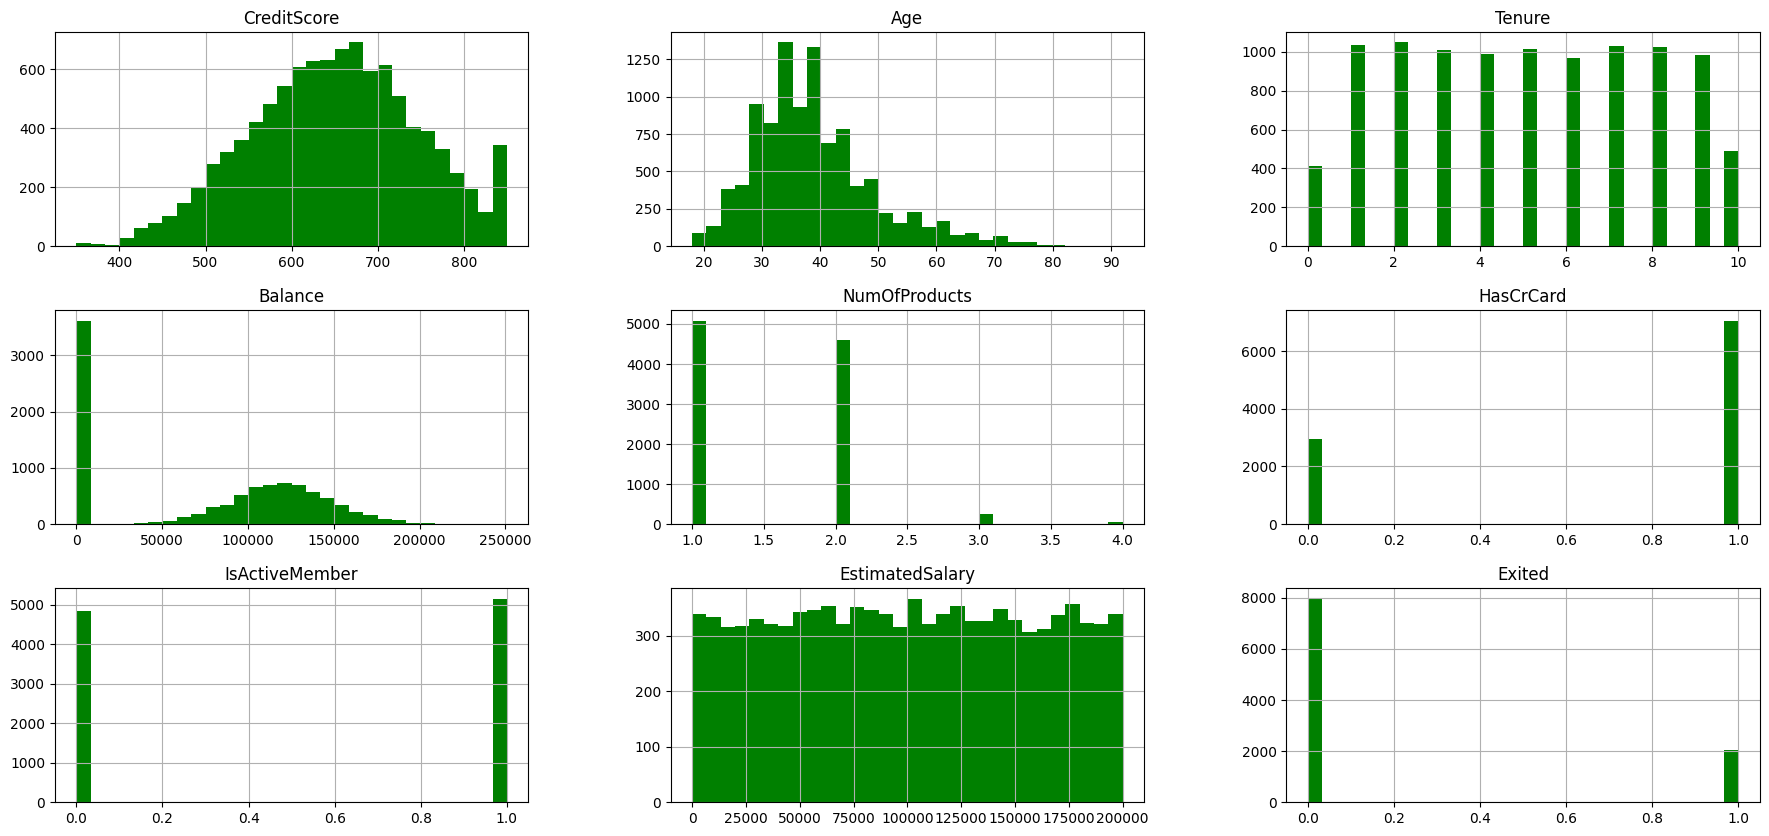

In [4]:
df.hist(bins = 30, figsize=(22, 10), color = 'green');

Since this dataset is so large, it can be hard to tell exactly whether or not a distribution is normal. In order to proceed with my analysis, I will check for normality using the Anderson test.

I picked the Anderson test for the creditscore variable since more weight is given to the tails of the distribution. This is Useful in this situation because of the sharp uptick at the right-tail of 'CreditScore'. 

Additionally, the Anderson test is suitable for large sets of observations. The Shapiro-Wilk test for normality would probably determine the 'CreditScore' variable to be normally distributed, since it is an unsuitable test for large inputs.


In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    # Suppress warning. 
    # The warning states the shapiro wilk test is inaccurate for N > 5000.
    # Current N is 10000
    stat, p = shapiro(X['CreditScore'])
    print(f"Shapiro-Wilk Test: Stat = {round(stat, 3)}, p-val = {p}\n")


result = anderson(X['CreditScore'])
print(f"Anderson Test: test-stat = {round(result.statistic, 3)}, Critical Values = {result.critical_values}")

Shapiro-Wilk Test: Stat = 0.994, p-val = 3.470965102195083e-20

Anderson Test: test-stat = 5.458, Critical Values = [0.576 0.656 0.787 0.918 1.092]


The Anderson test statistic is 5.458. The critical values [0.576 0.656 0.787 0.918 1.092] correspond to significance levels [15%, 10%, 5%, 2.5% 1%]. Since the test statistic is greater than all critical values, we reject the null hypothesis. 

Compare this to the Shapiro-Wilk test. Since its p-value is less than 0.05, we would reject the null hypothesis and determine that the data is normally distributed. However, since the Shapiro test is not suitable for this dataset, we will disregard it.

Therefore, the Anderson test determined that 'CreditScore' is not normally distributed.

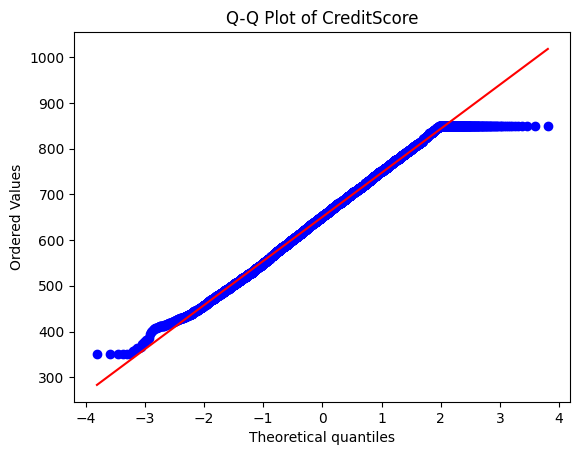

In [6]:
probplot(X['CreditScore'], dist = "norm", plot = plt)
plt.title("Q-Q Plot of CreditScore")
plt.show()

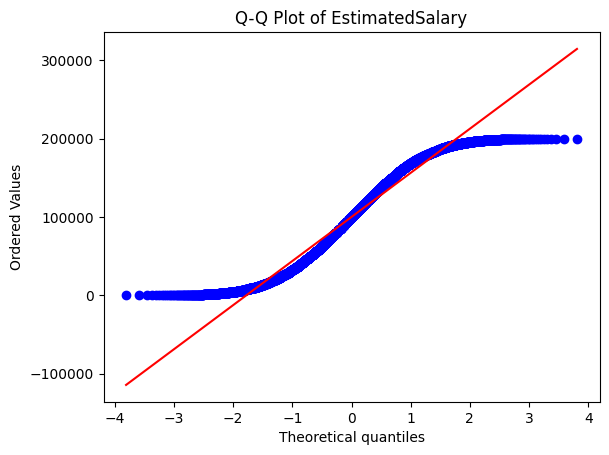

In [7]:
probplot(X['EstimatedSalary'], dist = "norm", plot = plt)
plt.title("Q-Q Plot of EstimatedSalary")
plt.show()

When looking at the "CreditScore" Q-Q Plot, it is obviously not normally distributed. Also, I threw in the "EstimatedSalary" Q-Q plot. It follows a more uniform like distribution.

We can visually inspect the previously produced histograms to determine that the "Balance" variable will behave simalarly.


# Why use a neural network



Since the data is not normally distributed, we need a non-parametric model. Logistic regression would require manual feature engineering to capture non-linear relationships, whereas a neural network is capable of automatically learning these patterns. This greatly cuts down on the amount of pre-processing work, since we only need to encode the categorical variables and scale all the features.

The non-linear nature of this data, non-normal distribution, as well as the mix of categorical and quantitative data suggests that a neural network is a good model to build.

# Label Encoding
Since we have two categorical variables, we must encode them before proceeding with the analysis.

In [8]:
adjust_length = 17 # offset for output formatting

for col in X:
    print(f"{col.ljust(adjust_length)} : {X[col].dtypes}")
print(f"{("Exited").ljust(adjust_length)} : {Y['Exited'].dtypes}")

CreditScore       : int64
Geography         : object
Gender            : object
Age               : int64
Tenure            : int64
Balance           : float64
NumOfProducts     : int64
HasCrCard         : int64
IsActiveMember    : int64
EstimatedSalary   : float64
Exited            : int64


The "Gender" variable will be encoded. A 0 represents the "Female" gender, a 1 represents the "Male" Gender.

Similarly, the "Geography" variable will be encoded. Each geographical location will recieve its own binary column, with a 1 occurring in the column where the observation is located.

In [9]:
Encoder = LabelEncoder()
X['Gender'] = Encoder.fit_transform(X.iloc[:, 2]).astype(int)

display((X.loc[:, 'CreditScore':'Gender']).iloc[0 : 5])


print(f"{str(X['Gender'].name)} : {X['Gender'].dtypes}")


,CreditScore,Geography,Gender
0,619,France,0
1,608,Spain,0
2,502,France,0
3,699,France,0
4,850,Spain,0


Gender : int64


Now, the "Gender" variable is represented as an integer.

Next, we must encode the "Geography" variable.

In [10]:
X = pd.get_dummies(X, columns=['Geography'], drop_first=True)

# Cast geography variables to integers
for col in X.columns:
    if 'Geography_' in col:
        X[col] = X[col].astype('int64')

for col in X:
    print(f"{col.ljust(adjust_length)} : {X[col].dtypes}")

CreditScore       : int64
Gender            : int64
Age               : int64
Tenure            : int64
Balance           : float64
NumOfProducts     : int64
HasCrCard         : int64
IsActiveMember    : int64
EstimatedSalary   : float64
Geography_Germany : int64
Geography_Spain   : int64


Now all of the variables are represented numerically.

In [11]:
fin_df = X.copy()
fin_df['Exited'] = Y

display(fin_df.iloc[0 : 5])

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,0,0,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,0,42,8,159660.80,3,1,0,113931.57,0,0,1
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,1,0


# Feature Scaling


to-do: 

       - Perform basic EDA BEFORE encoding / scaling
       - Scale features
       - Perform EDA AFTER encoding/scaling
       - Build neural network
       - Optimize NN
       - Analyze NN accuracy
       - Review + Document
       - Publish

